# How to compare two fields?
# Similarity functions

## 1. Use FuzzyConnector from Suricate to apply fuzzy scoring

In order to compare two fields, traditional methods give you a boolean: either the two fields are exactly the same, or they are not. But we need a more fuzzier, gradual approach for strings. This is called fuzzy scoring. We can use the awesome library *fuzzywuzzy* for this approach. The Levenshtein distance is the metrics used for fuzzy scoring in fuzzywuzzy

As an example, the *Suricate* package already has some datasets about companies incorporated.   
This data consists of two tables, called "*source*" and "*target*"

In [1]:
from fuzzywuzzy.fuzz import ratio
ratio('hello world', 'hello wrld')

95

In [2]:
from suricate.data.companies import getsource, gettarget
source = getsource(nrows=300)[['name']]
target = gettarget(nrows=300)[['name']]
X = [source, target]

We use the fuzzy connector to compare each row of *left* with each row of *right*    
The fuzzy connector has the following scores, from 0 (minimum) to 1 (maximum):
- 'exact' (1 if exact match, 0 otherwise)
- 'simple' (from Fuzzywuzzy ratio)
- 'token' (from Fuzzywuzzy token_set_ratio)
- 'contains' (1 if one string is a substring of another, 0 otherwise)
- 'vincenty' --> returns the Vincenty distance between two sets of coordinates

In [3]:
from suricate.dftransformers import DfApplyComparator
simpleratio = DfApplyComparator(ratio='simple', on='name')
y_simple = simpleratio.fit_transform(X)
y_simple

array([[0.56],
       [0.2 ],
       [0.48],
       ...,
       [0.47],
       [0.55],
       [0.19]])

In [4]:
from suricate.dftransformers import cartesian_join
import numpy as np

In [5]:
X_sbs = cartesian_join(source=source, target=target).set_index(['ix_source', 'ix_target'])
X_sbs['simpleratio'] = y_simple
# Adding the token ratio 
X_sbs['tokenratio'] = DfApplyComparator(on='name', ratio='token').fit_transform(X)
X_sbs.sort_values(by='simpleratio', ascending=False, inplace=True)

### Finding examples of very close, but not exact matches

In [6]:
avg_score = np.mean(X_sbs[['simpleratio', 'tokenratio']], axis=1)
veryclosematches = (avg_score >= 0.85) & (avg_score <0.95)
X_sbs.loc[veryclosematches].sample(10)

,,name_source,name_target,simpleratio,tokenratio
ix_source,ix_target,,,,
1cdf9fef,b5729da0,buerklin ohg,brklin ohg,0.91,0.91
225abc01,f714494d,marconi selenia,msc marconi selenia,0.88,0.88
f2e19b58,c4f36f6e,altron gmbh co kg,altran gmbh co kg,0.94,0.94
f0d34671,d9c1213d,hamilton sundstrand,hamilton sundstrand ca,0.93,0.93
591099fe,6b425170,nespresso deutschland gmbh,esso deutschland gmbh,0.89,0.89
f7da5ee1,484866fb,e a elektro automatik gmbh,ea elektro automatik,0.87,0.87
78b4a267,b5729da0,buerklin ohg,brklin ohg,0.91,0.91
42778260,b5729da0,buerklin ohg,brklin ohg,0.91,0.91
b5729da0,42778260,brklin ohg,buerklin ohg,0.91,0.91


### Finding examples of potentially close matches

In [7]:
closematches = (avg_score >= 0.70) & (avg_score <0.85)
X_sbs.loc[closematches].sample(10)

,,name_source,name_target,simpleratio,tokenratio
ix_source,ix_target,,,,
39734970,c393f4db,oracle deutschland gmbh,oracle deutschland bv co kg,0.80,0.80
4c115719,ec8b00e5,hamilton sundstrand aerospace,hamilton sundstrand,0.79,0.79
62417f75,0a335a51,r g gmbh,gr gmbh,0.80,0.80
de01875a,4828705a,cpd lieferanten div inland,diverse lieferanten inland,0.77,0.77
782a5b93,37f33f8a,3p gmbh,asup gmbh,0.75,0.75
6694cef8,73596a84,roth gmbh und co kg,brueggemann gmbh und co kg,0.71,0.71
1f9ecb03,cbb76bc4,sinus electronic gmbh,engelking elektronik gmbh,0.70,0.70
3c32bf99,68f7421e,kerb konus vertriebs gmbh,db vertrieb gmbh,0.73,0.73
1b69ccb6,f1abc471,nespresso deutschland gmbh,albert berner deutschland gmbh,0.71,0.71


### Conclusion
From the previous examples above, we can see that the edit distance between two strings may be a good indicator to tell if two strings should be understood as describing the same entity - they should be read the same. But it is not a perfect indicator. Some close strings do not describe the same entity although they have a high score

### Simple ratio or token ratio?
Here is an example of the comparison of the fuzzywuzzy simple score vs token score. Although the two scores are obviously closely correlated, they are not identical and it can be a good idea to compute both of them.    
From this chart also, we notice a pattern: most scores fall within the range of (0, 0.5).

In [8]:
X_sbs['simpleratio'].describe()

count    90000.000000
mean         0.296476
std          0.101991
min          0.000000
25%          0.240000
50%          0.290000
75%          0.350000
max          1.000000
Name: simpleratio, dtype: float64

In [9]:
# 95% of the scores fall under this threshold
np.percentile(avg_score, q=95)

0.47

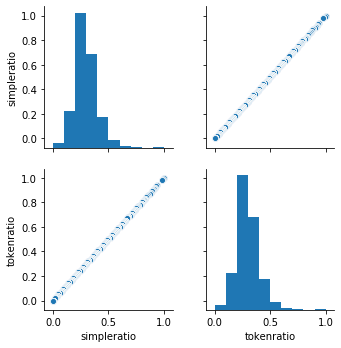

In [10]:
from seaborn import pairplot
%matplotlib inline
pairplot(X_sbs[['simpleratio', 'tokenratio']])

## 2. Use tokenization and cosine similarity


There are some drawbacks to using python-levenshtein. It is expensive to compute. Some other methods (n-gram) can be faster, and may allow for tf-idf comparison. Suricate has a transformer, the Vectorizer, that performs the following steps:
- tokenize the two strings to compare (Vectorizer, using TfIdf Vectorizer)
- computes the frequency of the token
- compare the two tokenized strings using cosine similarity

It can be used to tokenize on whole words (analyzer='word') or on each characters (analyzer='char')

In [11]:
from suricate.dftransformers import VectorizerConnector
X_sbs['vectorizer_word'] = VectorizerConnector(on='name', analyzer='word', ngram_range=(1,2)).fit_transform(X)
X_sbs['vectorizer_char'] = VectorizerConnector(on='name', analyzer='char', ngram_range=(1,2)).fit_transform(X)

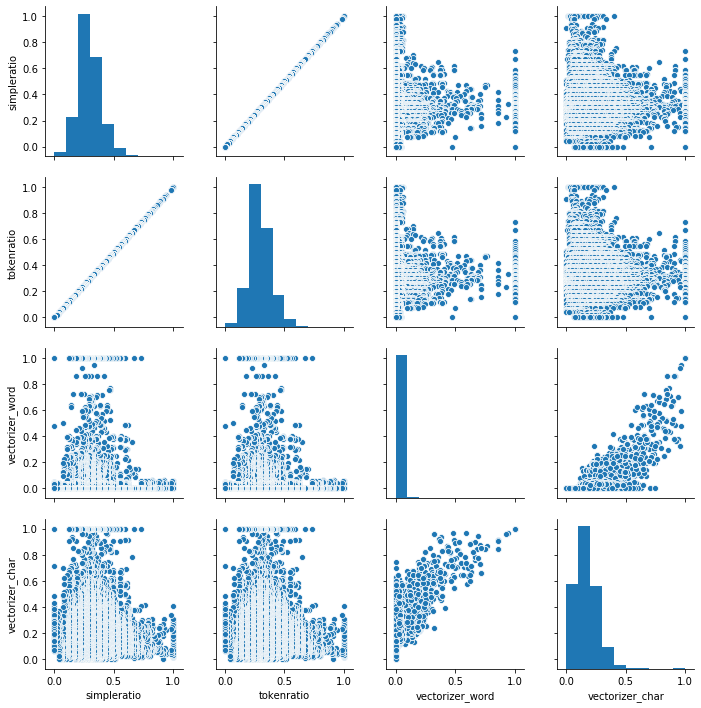

In [12]:
pairplot(X_sbs[['simpleratio', 'tokenratio', 'vectorizer_word', 'vectorizer_char']]);

## Which similarity function to use?

### For IDs: use Exact Connector
IDs (Example: Social Security Number, Tax codes, phone number, etc...) are usually not prone to typos and precise: You might want to use an Exact connector (i.e. 0 or 1).   

In [13]:
from suricate.dftransformers import ExactConnector

### For IDs with prefixes or Suffixes
Some IDs may be written with or without a prefix, depending on the input.
- entering a local area code for telephone number: 012 345 6789 or 0049 12 345 6789 (local area code for Germany)
- An IBAN contains the bank account number, plus a prefix the determine the credit institute, and a check sum digits as a suffix
- A VAT Code in the European Union contains the local registry number, plus a prefix, plus a suffix (a checksum in some countries)

If you are comparing then two columns where the assignement of prefix and suffix is not standardized, you might want to use the 'contain' score, or a token score with a large n-gram range

### For Fuzzy Strings comparison

#### If low volume of data: Use Fuzzy Connector    
- If only one token (i.e. single words): use simple ratio    
- If lots of tokens: use token ratio    


#### If high volume of data: Use Vectorizer connector
- gain in speed
- gain in accuracy as the Tf-Idf score is more accurate than the levenshtein score on a large number of samples

### For Geographical coordinates:
- use the Vincenty Distance

## Next topic: Pipeline different scoring methods for machine learning

In [14]:
print('end')

end
